In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

df_meta_path = data_dir /'13cyc'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


## Read info

In [5]:
# Helper functions
import napari 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):
    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

def get_loc_ppi(df, Condition, FOV, x_min, y_min, x_max, y_max, PPI_name):
    df_ppi = df[(df.Condition == Condition) & (df.FOV == FOV)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points, df_ppi

In [6]:
# Read PPI
PPI_save_path =  data_dir / '13cyc' / 'PPI'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)

df = pd.concat(dfs)

# Get nuclei and cell count
g = df.groupby(['Condition', 'FOV', 'PPI', 'Cyto']).size()
df_cell = pd.DataFrame({'Count Cyto': g}).reset_index()
df_cell = df_cell[df_cell.Cyto != 0]
df_cell.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_cell']
df_cell = (df_cell.pivot_table(values='Count_cell', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_cell', var_name='PPI')
)

g = df.groupby(['Condition', 'FOV', 'PPI', 'Nuclei_Cell']).size()
df_nuclei = pd.DataFrame({'Count Nuclei': g}).reset_index()
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Nuclei', 'Count Nuclei']
df_nuclei= df_nuclei[df_nuclei.Nuclei != 0]
df_nuclei.columns = ['Condition', 'FOV', 'PPI', 'Id', 'Count_nuclei']
df_nuclei = (df_nuclei.pivot_table(values='Count_nuclei', columns='PPI', index=['Condition', 'FOV','Id'])
.fillna(0)
.reset_index()
.melt(id_vars=['Condition', 'FOV','Id'], value_name='Count_nuclei', var_name='PPI')
)

# Combine count
df_all = df_cell.merge(df_nuclei, how='left', on=['Condition', 'FOV', 'PPI', 'Id']).fillna(0)
df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei'],'Count_cell'] = df_all.loc[df_all['Count_cell'] < df_all['Count_nuclei']]['Count_nuclei']
df_all['Count_nuclei'] = df_all['Count_nuclei'].astype(int)
df_all['Count_cyto'] = df_all['Count_cell'] - df_all['Count_nuclei']

In [7]:
df_subset = df_all[(df_all.Condition == 'control') & (df_all.FOV == 'FW2')]

In [8]:
# Get images
index = 3
row = df_imgs.iloc[index]
print(row)
path = row.Path

with h5py.File(path, 'r') as f:
    markers = f['imgs'].attrs['Marker']
    imgs = f['imgs'][:]

Condition                                              control
FOV                                                        FW2
Path         y:\coskun-lab\Thomas\23_PLA_revision\data\13cy...
Name: 3, dtype: object


In [9]:
# import napari 

# napari.view_image(imgs, name=markers, channel_axis=0, visible=False)

## Read some regions

In [10]:
image_dir = (Path().cwd().parents[0] / 'figures').absolute() / 'variation'
image_dir.mkdir(parents=True, exist_ok=True)

In [11]:
df = df.rename(columns={'x': 'row', 'y': 'column'})
df.head()

,Cyto,row,column,PPI,Nuclei,Nuclei_Cell,Condition,FOV
0,0,2736,7959,Sox2/Oct4,0,0,100nM,FW1
1,0,3372,1682,Sox2/Oct4,0,0,100nM,FW1
2,0,19,7286,Sox2/Oct4,0,0,100nM,FW1
3,0,3204,7861,Sox2/Oct4,0,0,100nM,FW1
4,928,3281,1355,Sox2/Oct4,0,0,100nM,FW1


In [12]:
PPI_cycles = 'p-ERK/c-MYC'
colors = ['magenta', 'lime']

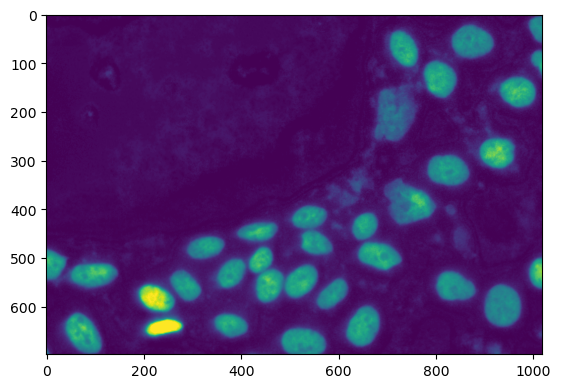

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\2333457556.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'13cyc_ROI0.tif', removeBorders(screenshot))


In [13]:
# mid region 
x_min, x_max = 40, 1059
y_min, y_max = 1700, 2398

plt.imshow(imgs[0, y_min:y_max, x_min:x_max])
plt.show()

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi_roi0 = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=8,face_color=colors[0],)

# Get screenshot
screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
viewer.close()
# Save image
tiff.imsave(image_dir / f'13cyc_ROI0.tif', removeBorders(screenshot))

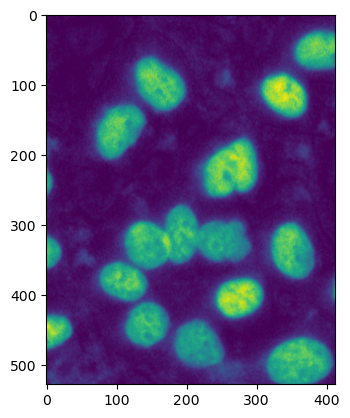

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\1794770664.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'13cyc_ROI1.tif', removeBorders(screenshot))


In [14]:
# High region 
x_min, x_max = 0, 413
y_min, y_max = 225, 753

plt.imshow(imgs[0, y_min:y_max, x_min:x_max])
plt.show()

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi_roi1 = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=8,face_color=colors[0],)

# Get screenshot
screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
viewer.close()
# Save image
tiff.imsave(image_dir / f'13cyc_ROI1.tif', removeBorders(screenshot))

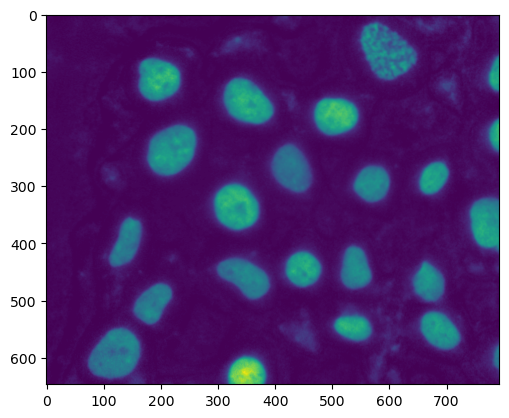

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\3242758087.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'13cyc_ROI2.tif', removeBorders(screenshot))


In [15]:
# low region 
x_min, x_max = 5151, 5944
y_min, y_max = 1863, 2510

plt.imshow(imgs[0, y_min:y_max, x_min:x_max])
plt.show()

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi_roi2 = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=8,face_color=colors[0],)

# Get screenshot
screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
viewer.close()
# Save image
tiff.imsave(image_dir / f'13cyc_ROI2.tif', removeBorders(screenshot))

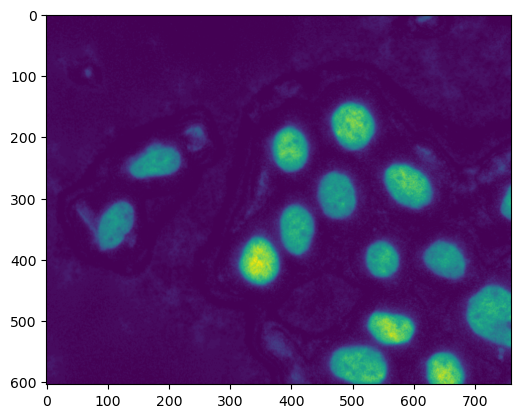

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\2707487271.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'13cyc_ROI3.tif', removeBorders(screenshot))


In [16]:
# low region 
x_min, x_max = 1848, 2607
y_min, y_max = 297, 901

plt.imshow(imgs[0, y_min:y_max, x_min:x_max])
plt.show()

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi_roi3 = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=8,face_color=colors[0],)

# Get screenshot
screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
viewer.close()
# Save image
tiff.imsave(image_dir / f'13cyc_ROI3.tif', removeBorders(screenshot))

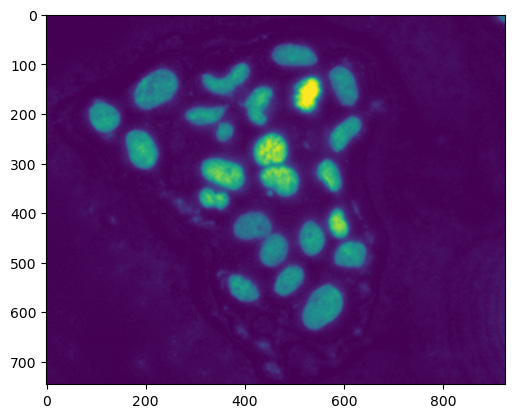

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\3463144955.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'13cyc_ROI4.tif', removeBorders(screenshot))


In [17]:
# intra region variability
x_min, x_max = 3503, 4429
y_min, y_max = 887, 1633

plt.imshow(imgs[0, y_min:y_max, x_min:x_max])
plt.show()

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi_roi4 = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=8,face_color=colors[0],)

# Get screenshot
screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
viewer.close()
# Save image
tiff.imsave(image_dir / f'13cyc_ROI4.tif', removeBorders(screenshot))

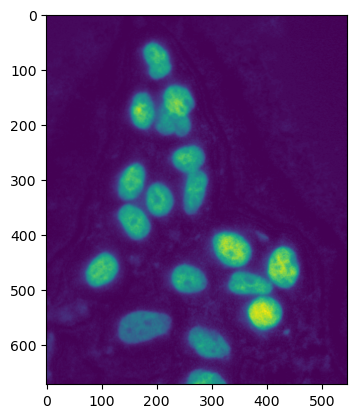

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\2988165088.py:22: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_dir / f'13cyc_ROI5.tif', removeBorders(screenshot))


In [18]:
# intra region variability
x_min, x_max = 2905, 3451
y_min, y_max = 1300, 1971

plt.imshow(imgs[0, y_min:y_max, x_min:x_max])
plt.show()

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi_roi5 = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=8,face_color=colors[0],)

# Get screenshot
screenshot = viewer.screenshot(size=np.array(dapiImg.shape)*2)
viewer.close()
# Save image
tiff.imsave(image_dir / f'13cyc_ROI5.tif', removeBorders(screenshot))

## Create whole FOV and Bbox

In [19]:
def make_bbox(bbox_extents):
    """Get the coordinates of the corners of a
    bounding box from the extents

    Parameters
    ----------
    bbox_extents : list (4xN)
        List of the extents of the bounding boxes for each of the N regions.
        Should be ordered: [min_row, min_column, max_row, max_column]

    Returns
    -------
    bbox_rect : np.ndarray
        The corners of the bounding box. Can be input directly into a
        napari Shapes layer.
    """
    minr = bbox_extents[0]
    minc = bbox_extents[1]
    maxr = bbox_extents[2]
    maxc = bbox_extents[3]

    bbox_rect = np.array(
        [[minr, minc], [maxr, minc], [maxr, maxc], [minr, maxc]]
    )
    # bbox_rect = np.moveaxis(bbox_rect, 2, 0)

    return bbox_rect

In [20]:
# intra region variability
x_min, x_max = 0, 6521
y_min, y_max = 0, 3399

# Get DAPI image
dapiImg = imgs[0, y_min:y_max, x_min:x_max]

# Get ppi location
points, df_ppi = get_loc_ppi(df, row.Condition, row.FOV, x_min, y_min, x_max, y_max, PPI_cycles) 

# Napari viewer
viewer = napari.view_image(dapiImg, colormap='blue')
points_layer = viewer.add_points(points, size=15,face_color=colors[0],)

# Add rectangle
# intra region variability
x_min, x_max = 40, 1059
y_min, y_max = 1700, 2398
bbox_rects = make_bbox([y_min, x_min, y_max, x_max])
shapes_layer = viewer.add_shapes(
        bbox_rects,
        opacity=1,
        face_color='transparent',
        edge_color='red',
        edge_width=30, 
        name='bbx1'
    )

x_min, x_max = 0, 413
y_min, y_max = 225, 753
bbox_rects = make_bbox([y_min, x_min, y_max, x_max])
shapes_layer = viewer.add_shapes(
        bbox_rects,
        opacity=1,
        face_color='transparent',
        edge_color='red',
        edge_width=30, 
        name='bbx2'
    )

x_min, x_max = 5151, 5944
y_min, y_max = 1863, 2510
bbox_rects = make_bbox([y_min, x_min, y_max, x_max])
shapes_layer = viewer.add_shapes(
        bbox_rects,
        opacity=1,
        face_color='transparent',
        edge_color='red',
        edge_width=30, 
        name='bbx3'
    )

x_min, x_max = 1848, 2607
y_min, y_max = 297, 901
bbox_rects = make_bbox([y_min, x_min, y_max, x_max])
shapes_layer = viewer.add_shapes(
        bbox_rects,
        opacity=1,
        face_color='transparent',
        edge_color='red',
        edge_width=30, 
        name='bbx4'
    )

x_min, x_max = 3503, 4429
y_min, y_max = 887, 1633
bbox_rects = make_bbox([y_min, x_min, y_max, x_max])
shapes_layer = viewer.add_shapes(
        bbox_rects,
        opacity=1,
        face_color='transparent',
        edge_color='red',
        edge_width=30, 
        name='bbx5'
    )

x_min, x_max = 2905, 3451
y_min, y_max = 1300, 1971
bbox_rects = make_bbox([y_min, x_min, y_max, x_max])
shapes_layer = viewer.add_shapes(
        bbox_rects,
        face_color='transparent',
        edge_color='red',
        edge_width=30, 
        name='bbx6'
    )

## Statistics

In [21]:
df_ppi = df_all[df_all.PPI == PPI_cycles]
df_ppi.head()

,Condition,FOV,Id,PPI,Count_cell,Count_nuclei,Count_cyto
26832,100nM,FW1,36,p-ERK/c-MYC,12.0,0,12.0
26833,100nM,FW1,37,p-ERK/c-MYC,16.0,0,16.0
26834,100nM,FW1,41,p-ERK/c-MYC,42.0,8,34.0
26835,100nM,FW1,47,p-ERK/c-MYC,7.0,1,6.0
26836,100nM,FW1,50,p-ERK/c-MYC,20.0,4,16.0


In [22]:
cell_roi0 = df_ppi_roi0.Cyto.unique()
cell_roi1 = df_ppi_roi1.Cyto.unique()
cell_roi2 = df_ppi_roi2.Cyto.unique()
cell_roi3 = df_ppi_roi3.Cyto.unique()
cell_roi4 = df_ppi_roi4.Cyto.unique()
cell_roi5 = df_ppi_roi5.Cyto.unique()

cell_rois = [cell_roi0, cell_roi1, cell_roi2, cell_roi3, cell_roi4, cell_roi5]

In [23]:
df_rois = []
for i,cells in enumerate(cell_rois):
    df_roi = df_ppi[df_ppi.Id.isin(cells)]
    df_roi['ROI'] = f'ROI {i}'
    df_rois.append(df_roi)

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\3827751423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roi['ROI'] = f'ROI {i}'
C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\3827751423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roi['ROI'] = f'ROI {i}'
C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\3827751423.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [24]:
df_rois = pd.concat(df_rois)

In [25]:
df_rois

,Condition,FOV,Id,PPI,Count_cell,Count_nuclei,Count_cyto,ROI
27025,100nM,FW1,294,p-ERK/c-MYC,35.0,15,20.0,ROI 0
27038,100nM,FW1,309,p-ERK/c-MYC,5.0,3,2.0,ROI 0
27057,100nM,FW1,331,p-ERK/c-MYC,5.0,1,4.0,ROI 0
27061,100nM,FW1,336,p-ERK/c-MYC,24.0,3,21.0,ROI 0
27072,100nM,FW1,352,p-ERK/c-MYC,2.0,2,0.0,ROI 0
...,...,...,...,...,...,...,...,...
28891,control,FW2,346,p-ERK/c-MYC,9.0,1,8.0,ROI 5
28899,control,FW2,356,p-ERK/c-MYC,57.0,11,46.0,ROI 5
28902,control,FW2,359,p-ERK/c-MYC,23.0,3,20.0,ROI 5
28904,control,FW2,361,p-ERK/c-MYC,8.0,0,8.0,ROI 5


In [26]:
# Boxplot per cell
plotting = {
    "data": df_rois,
    "x": "ROI",
    "y": "Count_cell",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


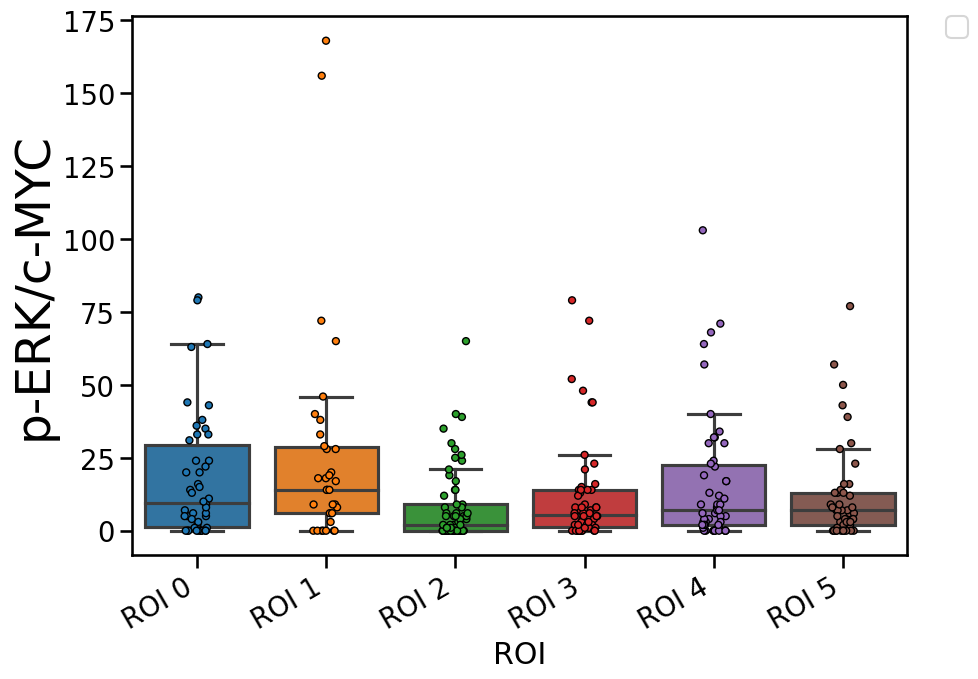

In [27]:
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(10,7))
    # ax = sns.boxplot(**plotting, showfliers=False, cut=0, bw_adjust=5, ax=ax, )
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, )
    # ax = sns.barplot(**plotting, ax=ax, )
    # ax = sns.swarmplot(**plotting, ax=ax, edgecolor='k', linewidth=1)
    ax = sns.stripplot(**plotting, edgecolor='k', linewidth=1, dodge=True)
    ax.set_ylabel('p-ERK/c-MYC', fontsize=35)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [28]:
from pycvcqv import coefficient_of_variation, cqv

df_coeff_Var = pd.DataFrame(df_rois.groupby(['ROI'])['Count_cell'].agg(cqv))
df_coeff_Var.loc['All'] = cqv(df_rois['Count_cell'])
df_coeff_Var = df_coeff_Var.reset_index()
df_coeff_Var

,ROI,Count_cell
0,ROI 0,0.9180
1,ROI 1,0.6547
2,ROI 2,1.0000
3,ROI 3,0.8361
4,ROI 4,0.8367
5,ROI 5,0.7333
6,All,0.8947


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


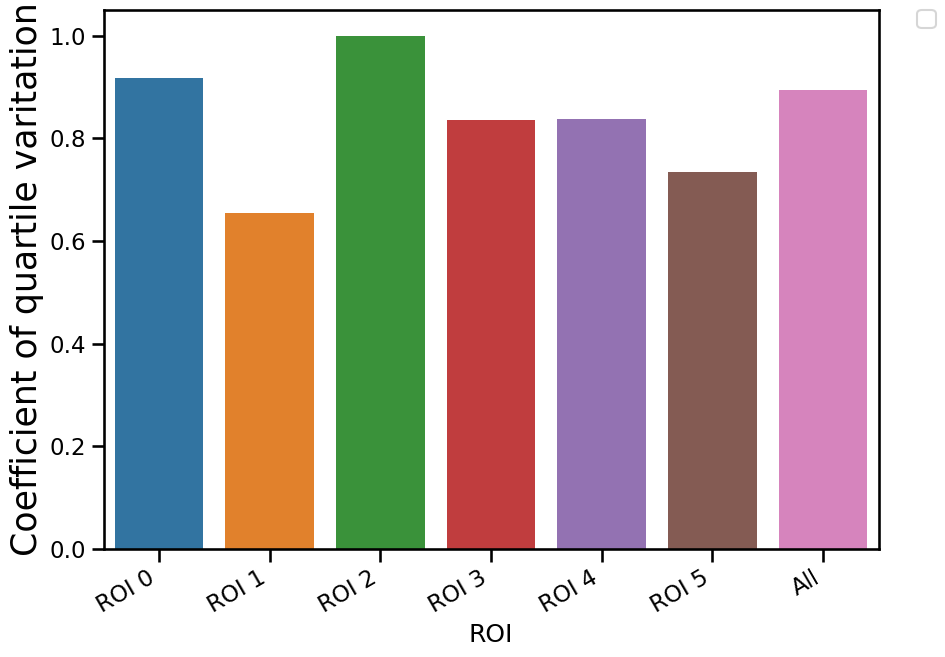

In [29]:
with sns.plotting_context('talk', font_scale=1.0):
    fig, ax = plt.subplots(figsize=(10,7))
    ax = sns.barplot(data = df_coeff_Var, x='ROI', y='Count_cell', ax=ax, )
    ax.set_ylabel('Coefficient of quartile varitation', fontsize=25)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [30]:
df_subset = df_rois[df_rois.ROI.isin(['ROI 1', 'ROI 2', 'ROI 5'])]
df_subset['Region'] = df_subset['ROI'].apply(lambda x: {'ROI 1': 'High', 'ROI 2': 'Low', 'ROI 5': 'Medium'}.get( x,x))

C:\Users\thu71\AppData\Local\Temp\ipykernel_1182880\4196596053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Region'] = df_subset['ROI'].apply(lambda x: {'ROI 1': 'High', 'ROI 2': 'Low', 'ROI 5': 'Medium'}.get( x,x))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


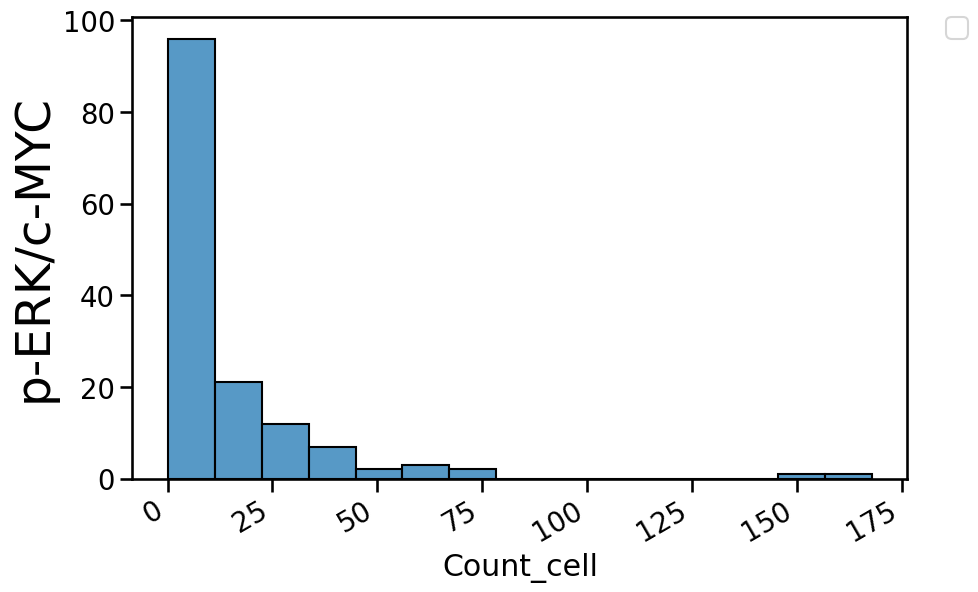

In [31]:
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.histplot(data=df_subset, x="Count_cell", bins=15,ax=ax)
    ax.set_ylabel('p-ERK/c-MYC', fontsize=35)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [32]:
# Boxplot per cell
plotting = {
    "data": df_subset,
    "x": "Region",
    "y": "Count_cell",
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


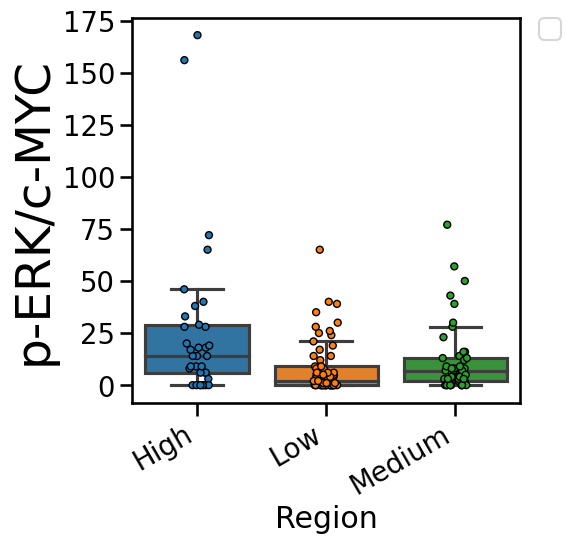

In [34]:
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(5,5))
    # ax = sns.boxplot(**plotting, showfliers=False, cut=0, bw_adjust=5, ax=ax, )
    ax = sns.boxplot(**plotting, showfliers=False, ax=ax, )
    ax = sns.stripplot(**plotting, ax=ax, edgecolor='k', linewidth=1)
    ax.set_ylabel('p-ERK/c-MYC', fontsize=35)
    plt.xticks(rotation=30, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [37]:
df_subset

,Condition,FOV,Id,PPI,Count_cell,Count_nuclei,Count_cyto,ROI,Region
26841,100nM,FW1,57,p-ERK/c-MYC,9.0,2,7.0,ROI 1,High
26878,100nM,FW1,104,p-ERK/c-MYC,8.0,1,7.0,ROI 1,High
26879,100nM,FW1,105,p-ERK/c-MYC,6.0,0,6.0,ROI 1,High
26894,100nM,FW1,122,p-ERK/c-MYC,6.0,4,2.0,ROI 1,High
26898,100nM,FW1,127,p-ERK/c-MYC,9.0,1,8.0,ROI 1,High
...,...,...,...,...,...,...,...,...,...
28891,control,FW2,346,p-ERK/c-MYC,9.0,1,8.0,ROI 5,Medium
28899,control,FW2,356,p-ERK/c-MYC,57.0,11,46.0,ROI 5,Medium
28902,control,FW2,359,p-ERK/c-MYC,23.0,3,20.0,ROI 5,Medium
28904,control,FW2,361,p-ERK/c-MYC,8.0,0,8.0,ROI 5,Medium


In [39]:
df_subset.groupby(['Condition', 'Region'])['Count_cell'].describe().to_clipboard()

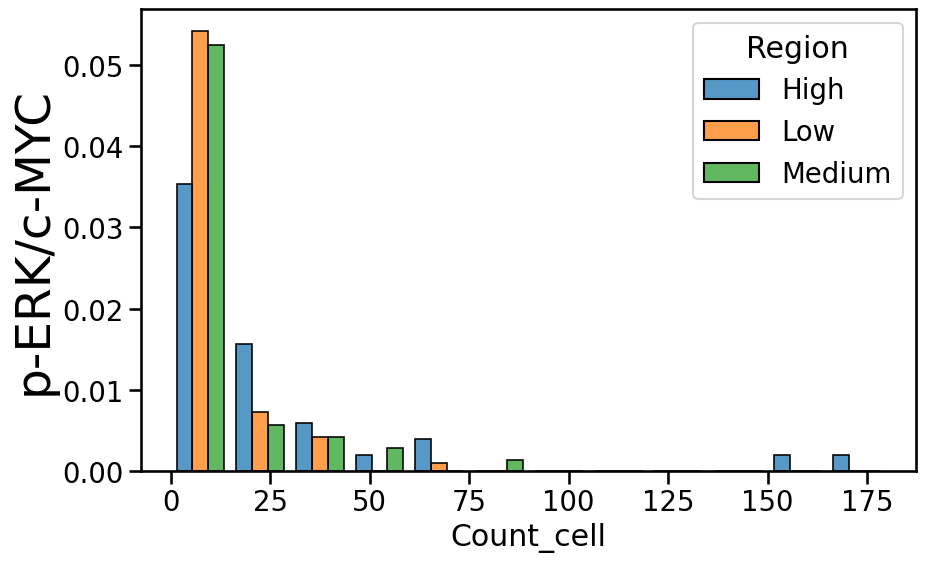

In [34]:
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.histplot(data=df_subset, x="Count_cell", hue='Region', ax=ax, binwidth=15,shrink=0.8, 
                      multiple="dodge",stat="density", common_norm=False, legend=True)
    ax.set_ylabel('p-ERK/c-MYC', fontsize=35)
    # plt.xticks(rotation=30, ha='right')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)y

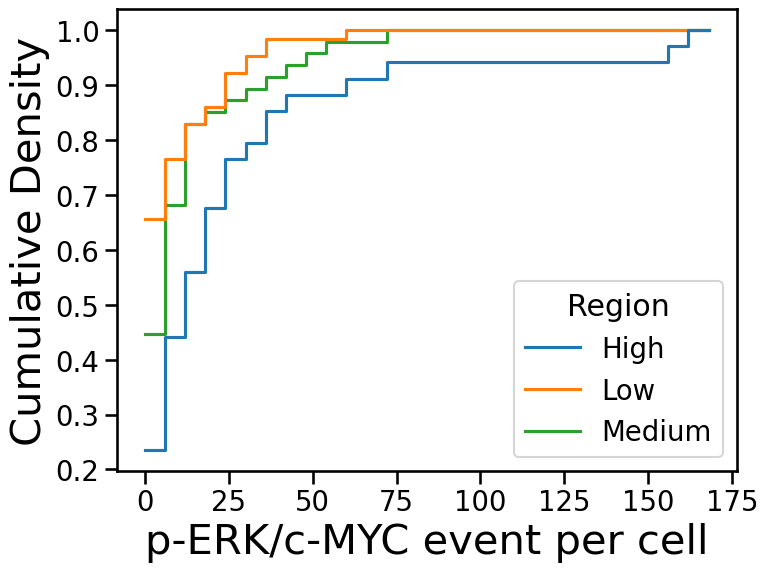

In [268]:
with sns.plotting_context('talk', font_scale=1.2):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.histplot(
        data=df_subset, x="Count_cell", hue='Region',
        element="step", fill=False, ax=ax, 
        cumulative=True, stat="density", common_norm=False,
    )
    ax.set_ylabel('Cumulative Density', fontsize=30)
    ax.set_xlabel('p-ERK/c-MYC event per cell', fontsize=30)
